<a href="https://colab.research.google.com/github/napoler/001pytorch/blob/master/Copy_of_Predictive_Maintenance_Predicting_when_a_machine_will_break.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predictive Maintenance - Predicting when a machine will break

---

## 1 - Introduction

We will consider that a manufacturing company uses many machines to build their final products. The factory is using IoT technologies via smart sensors to measure and save various kind of inputs from the physical environment and the state of their equipment.

Unfortunately, every time a machine breaks the production is stopped, which costs the company thousands of dollars in repair and late delivery fees. The factory manager asks the company Data Science team if it is possible to find a way to be more pro-active so as to optimize spending.

---

In [1]:
!pip install pysurvival

     |████████████████████████████████| 4.7 MB 4.0 MB/s 
  Created wheel for pysurvival: filename=pysurvival-0.1.2-cp37-cp37m-linux_x86_64.whl size=3773326 sha256=1925aba7ea3c71309244c896779bfca23d4ece18a3fde20a89054d7f98495234
  Stored in directory: /root/.cache/pip/wheels/1a/63/e2/32273d765a4e2f4ccac69c8adf97425ca80bab5d0c8447f120
  Created wheel for progressbar: filename=progressbar-2.5-py3-none-any.whl size=12082 sha256=f2190abf8fd10886983725ef66f00d1beb3eb367f9c9ac683264a70bafeeffd9
  Stored in directory: /root/.cache/pip/wheels/f0/fd/1f/3e35ed57e94cd8ced38dd46771f1f0f94f65fec548659ed855
Successfully built pysurvival progressbar


## 2 - Exploratory Data Analysis

### 2.1 - Dataset overview

In [21]:
# !unzip archive\ \(1\).zip
import pandas as pd
raw_dataset=pd.read_csv('/content/haberman.csv')  
print("The raw_dataset has the following shape: {}.".format(raw_dataset.shape))
raw_dataset.head(3)

The raw_dataset has the following shape: (305, 4).


,30,64,1,1.1
0,30,62,3,1
1,30,65,0,1
2,31,59,2,1


In [2]:
# Importing modules
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pysurvival.datasets import Dataset
%pylab inline

# Reading the dataset
raw_dataset = Dataset('maintenance').load()
print("The raw_dataset has the following shape: {}.".format(raw_dataset.shape))
raw_dataset.head(3)

Populating the interactive namespace from numpy and matplotlib
The raw_dataset has the following shape: (1000, 7).


,lifetime,broken,pressureInd,moistureInd,temperatureInd,team,provider
0,56,0,92.178854,104.230204,96.517159,TeamA,Provider4
1,81,1,72.075938,103.065701,87.271062,TeamC,Provider4
2,60,0,96.272254,77.801376,112.196170,TeamA,Provider1


In [3]:
raw_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   lifetime        1000 non-null   int64  
 1   broken          1000 non-null   int64  
 2   pressureInd     1000 non-null   float64
 3   moistureInd     1000 non-null   float64
 4   temperatureInd  1000 non-null   float64
 5   team            1000 non-null   object 
 6   provider        1000 non-null   object 
dtypes: float64(3), int64(2), object(2)
memory usage: 54.8+ KB


### 2.2 - From Categorical to numerical
There are 3 numerical features (`pressureInd`, `moistureInd`, `temperatureInd`) and 2 categorical features (`team`, `provider`). Let's encode the categorical variables as one-hot vectors and define the modeling features:

In [4]:
# Defining the time and event column
time_column = 'lifetime'
event_column = 'broken'

# Encoding the categorical variables as one-hot vectors
categories = ['provider', 'team']
dataset = pd.get_dummies(raw_dataset, columns = categories, drop_first=True)

# Defining the modeling features
features = np.setdiff1d(dataset.columns, ['lifetime', 'broken']).tolist()

### 2.3 - Null values and duplicates
The first thing to do is checking if the raw_dataset contains Null values and has duplicated rows.

In [5]:
# Checking for null values
N_null = sum(dataset[features].isnull().sum())
print("The raw_dataset contains {} null values".format(N_null)) #0 null values

# Removing duplicates if there exist
N_dupli = sum(dataset.duplicated(keep='first'))
dataset = dataset.drop_duplicates(keep='first').reset_index(drop=True)
print("The raw_dataset contains {} duplicates".format(N_dupli))

# Number of samples in the dataset
N = dataset.shape[0]

The raw_dataset contains 0 null values
The raw_dataset contains 0 duplicates


### 2.4 - Visual exploration and statistics

Let's check out/visualize the feature statistics:

#### 2.4.1 - Numerical features
We will display the boxplot and histogram of each feature

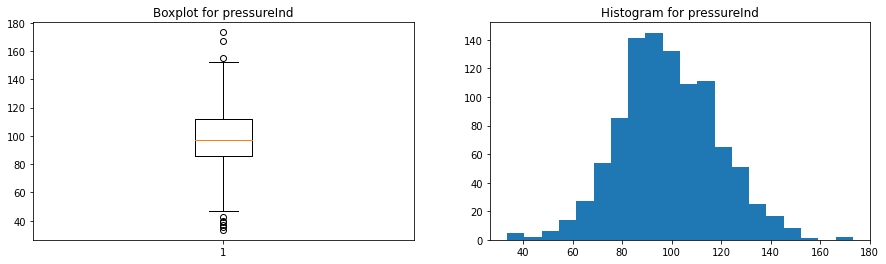

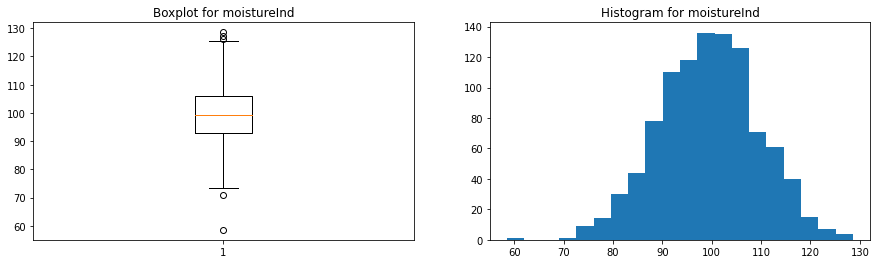

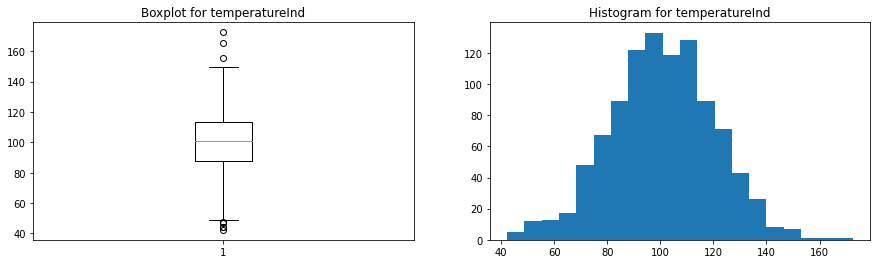

In [6]:
from matplotlib import pyplot as plt
for feature in ['pressureInd','moistureInd','temperatureInd']:

    # Creating an empty chart
    fig, ((ax1, ax2)) = plt.subplots(1, 2,  figsize=(15, 4))

    # Extracting the feature values
    x = raw_dataset[feature].values

    # Boxplot
    ax1.boxplot(x)
    ax1.set_title( 'Boxplot for {}'.format(feature) )

    # Histogram
    ax2.hist(x, bins=20)
    ax2.set_title( 'Histogram for {}'.format(feature) )

    # Display
    plt.show()

These features have very few outliers, so there's no real need to remove them, and they seem to follow normal distributions.

#### 2.4.2 - Categorical features
We will display the occurrences of the categories in a barchart for each feature

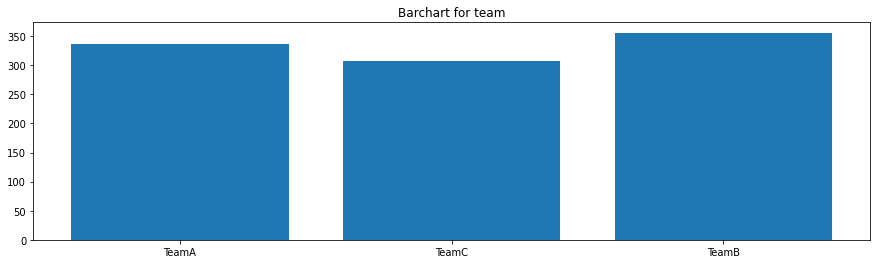

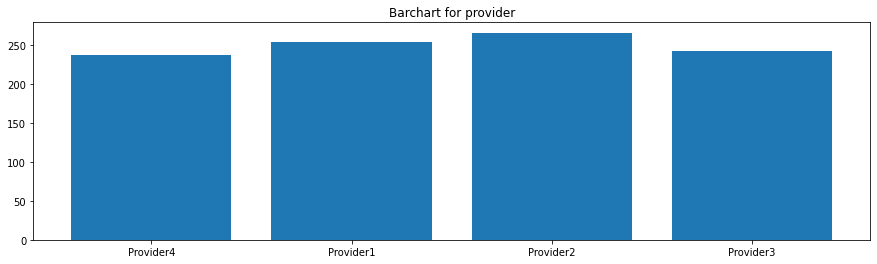

In [7]:
from collections import Counter
for feature in ['team', 'provider']:

    # Creating an empty chart
    fig, ax = plt.subplots(figsize=(15, 4))

    # Extracting the feature values
    x = raw_dataset[feature].values

    # Counting the number of occurrences for each category
    data = Counter(x)
    category = list(data.keys())
    counts = list(data.values())

    # Boxplot
    ax.bar(category, counts)

    # Display
    plt.title( 'Barchart for {}'.format(feature) )
    plt.show()

These features seem to be uniformly distributed.


#### 2.4.3 - Time & Event
We will display the occurrences of event and censorship, as well as the distribution of the time output variable for both situations.

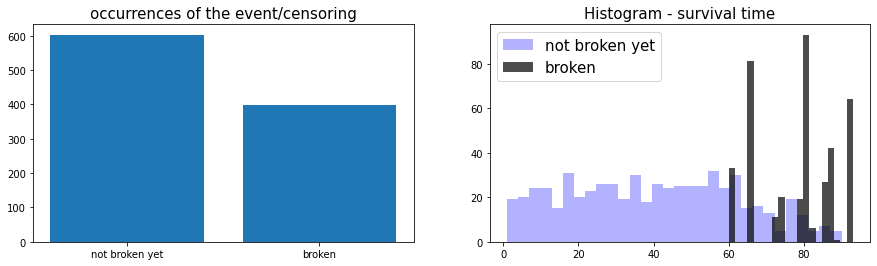

In [8]:
# Creating an empty chart
fig, ((ax1, ax2)) = plt.subplots(1, 2,  figsize=(15, 4))

# Counting the number of occurrences for each category 
data = Counter(raw_dataset['broken'].replace({0:'not broken yet', 1:'broken'}))
category = list(data.keys())
counts = list(data.values())
idx = range(len(counts))

# Displaying the occurrences of the event/censoring
ax1.bar(idx, counts)
ax1.set_xticks(idx)
ax1.set_xticklabels(category)
ax1.set_title( 'occurrences of the event/censoring', fontsize=15)

# Showing the histogram of the survival times for the censoring
time_0 = raw_dataset.loc[ raw_dataset['broken'] == 0, 'lifetime']
ax2.hist(time_0, bins=30, alpha=0.3, color='blue', label = 'not broken yet')

# Showing the histogram of the survival times for the events
time_1 = raw_dataset.loc[ raw_dataset['broken'] == 1, 'lifetime']
ax2.hist(time_1, bins=20, alpha=0.7, color='black', label = 'broken')
ax2.set_title( 'Histogram - survival time', fontsize=15)

# Displaying everything side-by-side
plt.legend(fontsize=15)
plt.show()

Here, we can see that 2/3 of the data is censored and that the failures start happening when the machine has been active for at least 60 weeks.

#### 2.4.4 - Correlations
Let's compute and visualize the correlation between the features

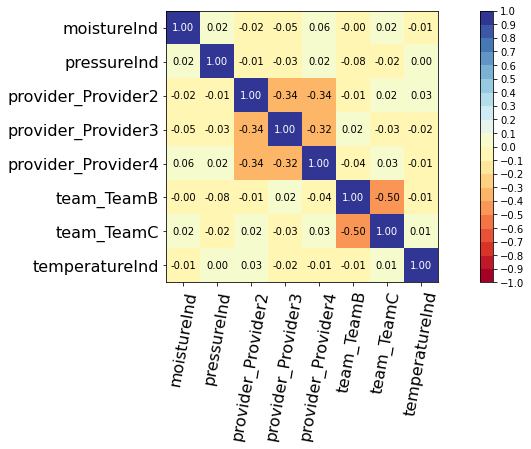

In [9]:
from pysurvival.utils.display import correlation_matrix
correlation_matrix(dataset[features], figure_size=(15, 5))

As we can see, there aren't any alarming correlations.

---

## 3 - Modeling
So as to perform cross-validation later on and assess the performances of the model, let's split the dataset into training and testing sets.

### 3.1 - Splitting between training and testing

In [10]:
# Building training and testing sets
from sklearn.model_selection import train_test_split
index_train, index_test = train_test_split( range(N), test_size = 0.3)
data_train = dataset.loc[index_train].reset_index( drop = True )
data_test  = dataset.loc[index_test].reset_index( drop = True )

# Creating the X, T and E inputs
X_train, X_test = data_train[features], data_test[features]
T_train, T_test = data_train[time_column], data_test[time_column]
E_train, E_test = data_train[event_column], data_test[event_column]

### 3.2 - Building a Linear MTLR model
Let's now fit a Linear MTLR model to the training set.

In [11]:
from pysurvival.models.multi_task import LinearMultiTaskModel

# Initializing the MTLR with a time axis split into 300 intervals
linear_mtlr = LinearMultiTaskModel(bins=300)

# Fitting the model
linear_mtlr.fit(X_train, T_train, E_train, num_epochs = 1000,
                init_method = 'orthogonal', optimizer ='rmsprop', 
                lr = 1e-3, l2_reg = 4,  l2_smooth = 4, )

LinearMultiTaskModel

We can take a look at the loss function values

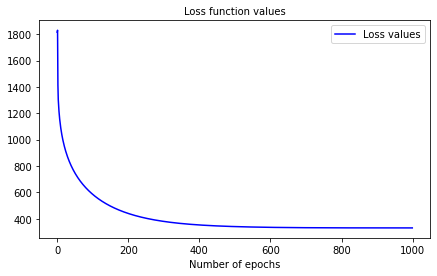

In [12]:
from pysurvival.utils.display import display_loss_values
display_loss_values(linear_mtlr, figure_size=(7, 4))

---

# 4 - Cross Validation
In order to assess the model performance, we previously split the original dataset into training and testing sets, so that we can now compute its performance metrics on the testing set:

## 4.1 - C-index
The C-index represents the global assessment of the model discrimination power: this is the model’s ability to correctly provide a reliable ranking of the survival times based on the individual risk scores. In general, when the C-index is close to 1, the model has an almost perfect discriminatory power; but it is close to 0.5, it has no ability to discriminate between low and high risk subjects.

In [13]:
from pysurvival.utils.metrics import concordance_index

c_index = concordance_index(linear_mtlr, X_test, T_test, E_test)
print('C-index: {:.2f}'.format(c_index)) #0.91

C-index: 0.94


As the c-index of the model (0.92 here) is close to 1, it seems that the model will yield satisfactory results in terms of survival times predictions.

### 4.2 - Brier Score
The Brier score measures the average discrepancies between the status and the estimated probabilities at a given time. Thus, the lower the score (usually below 0.25), the better the predictive performance. To assess the overall error measure across multiple time points, the Integrated Brier Score (IBS) is usually computed as well.

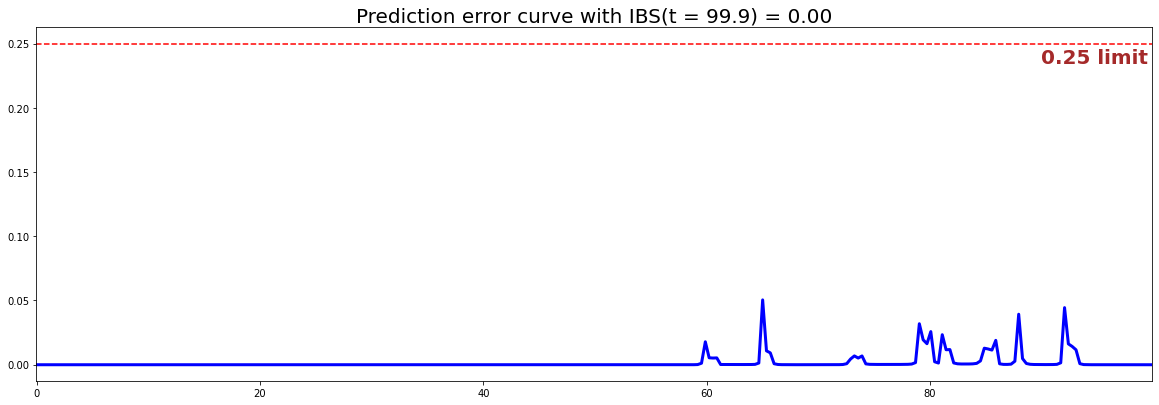

IBS: 0.00


In [14]:
from pysurvival.utils.display import integrated_brier_score
ibs = integrated_brier_score(linear_mtlr, X_test, T_test, E_test, t_max=100, 
                       figure_size=(20, 6.5) )
print('IBS: {:.2f}'.format(ibs)) #0.0

The IBS is very close to 0.0 on the entire model time axis. This indicates that the model will have very good predictive abilities.

---

# 5 - Predictions

## 5.1 - Overall predictions
Now that we have built a model that seems to provide great performances, let's compare the time series of the actual and predicted number of machines experiencing a failure, for each time t.

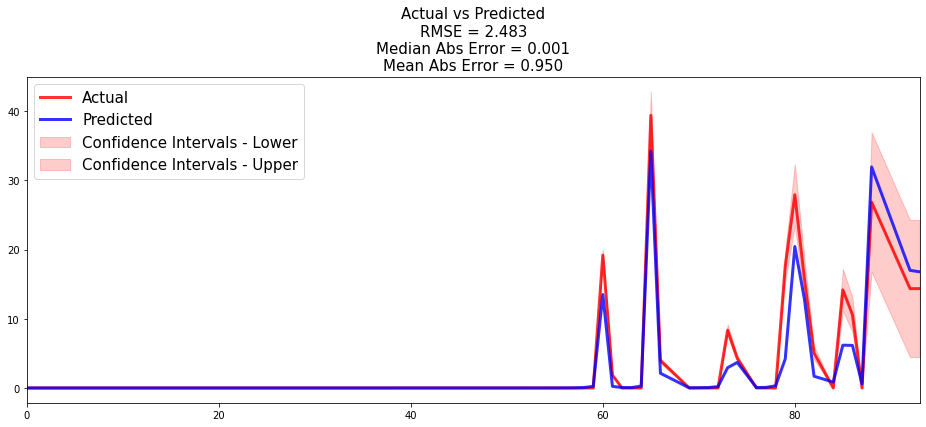

In [15]:
from pysurvival.utils.display import compare_to_actual
results = compare_to_actual(linear_mtlr, X_test, T_test, E_test,
                            is_at_risk = False,  figure_size=(16, 6), 
                            metrics = ['rmse', 'mean', 'median'])

* the time series of the actual and predicted number of machines that are still working, for each time t.

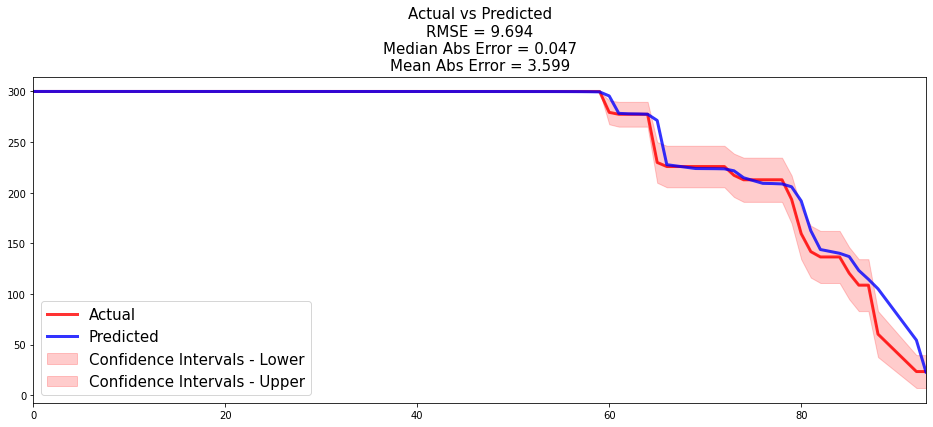

In [16]:
from pysurvival.utils.display import compare_to_actual
results = compare_to_actual(linear_mtlr, X_test, T_test, E_test,
                            is_at_risk = True,  figure_size=(16, 6), 
                            metrics = ['rmse', 'mean', 'median'])

Both comparisons show that the model do an excellent job predicting the number of machines that are still working or that failed for all times t.



---

## 5.2 - Individual predictions
Now that we know that we can provide reliable predictions for an entire cohort. Let's Compute the survival predictions at the individual level.

First, we can construct the risk groups based on risk scores distribution. The helper function create_risk_groups, which can be found in pysurvival.utils, will help us do that:

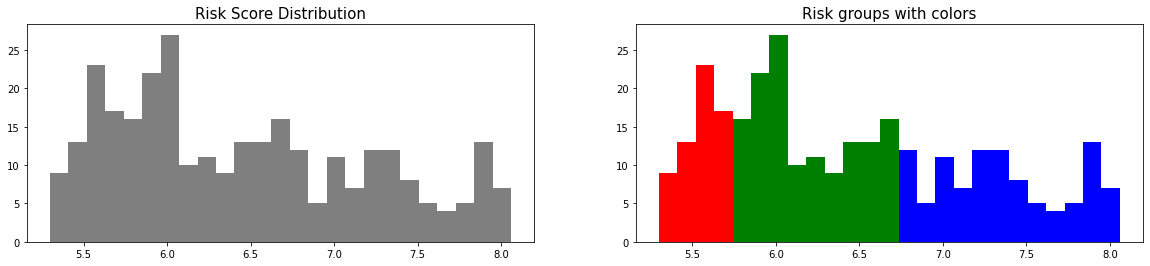

In [17]:
from pysurvival.utils.display import create_risk_groups
risk_groups = create_risk_groups(model=linear_mtlr, X=X_test,
    use_log = True, num_bins=25, figure_size=(20, 4),
    low={'lower_bound':0, 'upper_bound':5.7, 'color':'red'},
    medium={'lower_bound': 5.7, 'upper_bound': 6.7, 'color':'green'},
    high={'lower_bound':6.7, 'upper_bound':10, 'color':'blue'}
    )

Here, we can see that 3 main groups, low, medium and high risk groups, can be created. Because the C-index is high, the model will be able to perfectly rank the survival times of a random unit of each group, such that $t_{high} \leq t_{medium} \leq t_{low}$.

Let's randomly select individual unit in each group and compare the survival functions. To demonstrate our point, we will purposely select units which experienced an event to visualize the actual time of event.

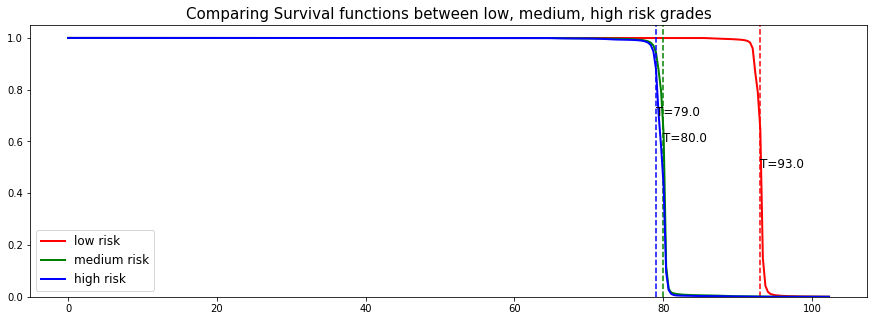

In [18]:
# Initializing the figure
fig, ax = plt.subplots(figsize=(15, 5))

# Selecting a random individual that experienced an event from each group
groups = []
for i, (label, (color, indexes)) in enumerate(risk_groups.items()) :

    # Selecting the individuals that belong to this group
    if len(indexes) == 0 :
        continue
    X = X_test.values[indexes, :]
    T = T_test.values[indexes]
    E = E_test.values[indexes]

    # Randomly extracting an individual that experienced an event
    choices = np.argwhere((E==1.)).flatten()
    if len(choices) == 0 :
        continue
    k = np.random.choice( choices, 1)[0]

    # Saving the time of event
    t = T[k]

    # Computing the Survival function for all times t
    survival = linear_mtlr.predict_survival(X[k, :]).flatten()

    # Displaying the functions
    label_ = '{} risk'.format(label)
    plt.plot(linear_mtlr.times, survival, color = color, label=label_, lw=2)
    groups.append(label)

    # Actual time
    plt.axvline(x=t, color=color, ls ='--')
    ax.annotate('T={:.1f}'.format(t), xy=(t, 0.5*(1.+0.2*i)), 
        xytext=(t, 0.5*(1.+0.2*i)), fontsize=12)

# Show everything
groups_str = ', '.join(groups)
title = "Comparing Survival functions between {} risk grades".format(groups_str)
plt.legend(fontsize=12)
plt.title(title, fontsize=15)
plt.ylim(0, 1.05)
plt.show()

As we can see, the model manages to perfectly predict the event time, here it corresponds to a sudden drop in the individual survival function.

---

# 6 - Conclusion
In this example, we have shown that it is possible to predict with great degree of certainty when a machine will fail. The Data Science team could predict the machines survival function every day, so that 1 or 2 weeks before the machine is supposed to fail, the factory manager is notified so that the necessary actions can be taken.

We can now save our model so as to put it in production and score future machines.

In [19]:
# Let's now save our model
from pysurvival.utils import save_model
save_model(linear_mtlr, '/Users/xxx/Desktop/pdm_linear_mtlr.zip')

OSError: ignored